In [1]:
%pylab inline
import pandas as pd
from functools import reduce, lru_cache

Populating the interactive namespace from numpy and matplotlib


# Data Preparation

In [2]:
all_data = pd.read_csv('ml-100k/u1.base', delimiter='\t', header=None)
all_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [3]:
tst_data = pd.read_csv('ml-100k/u1.test', delimiter='\t', header=None)
tst_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [4]:
users = max(all_data.user_id.max(), tst_data.user_id.max()) + 1
items = max(all_data.item_id.max(), tst_data.item_id.max()) + 1

In [5]:
train_matrix = zeros((users, items))
for i, r in all_data.iterrows():
    train_matrix[r.user_id, r.item_id] = r.rating

In [6]:
test_matrix = zeros((users, items))
for i, r in tst_data.iterrows():
    test_matrix[r.user_id, r.item_id] = r.rating

In [7]:
assert train_matrix.shape == test_matrix.shape

In [8]:
del all_data, tst_data # relase the memory for later use.

# Evaluation Metrics

In [9]:
mae = lambda p, r: mean(abs(r - p))

In [10]:
rmse = lambda p, r: sqrt(mean(pow(r-p, 2)))

In [11]:
def hmae(p, r, k=3):
    ri = r >= k
    return mean(abs(r[ri] - p[ri]))

# Feature Representation & Similarity Measures

## Matrix Factorization

In [12]:
def sgd_mf(ratings, p=None, q=None, factors=40, g=1e-2, l=1e-6, max_iters=100):
    rows, cols = ratings.shape
    nz = transpose(nonzero(ratings))
    if p is None:
        p = random.random_sample((rows, factors)) * 0.1
    if q is None:
        q = random.random_sample((cols, factors)) * 0.1
    for it in range(max_iters):
        for n, (u, i) in enumerate(nz):
            pu = p[u].copy()
            qi = q[i].copy()
            e = ratings[u, i] - dot(pu, qi.T)
            p[u] = pu + g * (e * qi - l * pu)
            if any(isnan(p[u]) | isinf(p[u])):
                print('%d p Nan/inf: %d %d %d %f' % (n, e, u, i, dot(pu, qi.T)))
                return p, q
            q[i] = qi + g * (e * pu - l * qi)
            if any(isnan(q[i]) | isinf(q[i])):
                print('%d q Nan/inf: %d %d %d %f' % (n, e, u, i, dot(pu, qi.T)))
                return p, q
    return p, q

In [13]:
p, q = sgd_mf(train_matrix)

In [14]:
any(isnan(p @ q.T))

False

In [15]:
mean(abs(train_matrix - p @ q.T)[nonzero(train_matrix)])

0.21962948656977505

In [16]:
mean(abs(test_matrix - p @ q.T)[nonzero(test_matrix)])

0.96533369546671743

In [17]:
p1, q1 = sgd_mf(train_matrix, max_iters=200)

In [18]:
any(isnan(p1 @ q1.T))

False

In [19]:
any(p1 @ q1.T < 0)

True

In [20]:
mean(abs(train_matrix - p1 @ q1.T)[nonzero(train_matrix)])

0.18052448970849433

In [21]:
mean(abs(test_matrix - p1 @ q1.T)[nonzero(test_matrix)])

1.0708644706818971

In [22]:
def get_simialrity_matrix(factors, measure):
    # by default, we generate the similarity matrix by the first dimension.
    dlen = factors.shape[0]
    similarity_matrix = zeros((dlen,) * 2)
    for i in range(dlen):
        for j in range(i+1, dlen):
            similarity_matrix[i, j] = similarity_matrix[j, i] = measure(factors[i, :], factors[j, :])
    return similarity_matrix

In [23]:
def pearson_similarity(a, b):
    assert a.shape == b.shape
    overlap = (a > 0) & (b > 0)
    if any(overlap):
        va = a[overlap]
        vb = b[overlap]
        n = sqrt(sum(pow(va - mean(va), 2))) * sqrt(sum(pow(vb - mean(vb), 2)))
        if n == 0:
            return 0
        else:
            return round(sum((va - mean(va)) * (vb - mean(vb))) / n, 6)
    return 0

In [24]:
ii_sim = get_simialrity_matrix(q, pearson_similarity)

In [25]:
ii_sim

array([[ 0.      , -0.344236, -0.070374, ...,  0.214914,  0.065766,
         0.200301],
       [-0.344236,  0.      , -0.241633, ...,  0.107102,  0.025409,
        -0.038236],
       [-0.070374, -0.241633,  0.      , ...,  0.127605,  0.124311,
        -0.28308 ],
       ..., 
       [ 0.214914,  0.107102,  0.127605, ...,  0.      , -0.024183,
        -0.208493],
       [ 0.065766,  0.025409,  0.124311, ..., -0.024183,  0.      ,  0.162   ],
       [ 0.200301, -0.038236, -0.28308 , ..., -0.208493,  0.162   ,  0.      ]])

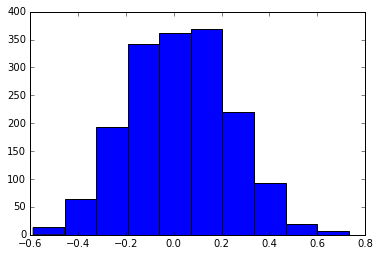

In [26]:
hist(ii_sim[2]);

In [27]:
ii_sim2 = get_simialrity_matrix(q1, pearson_similarity)

In [28]:
ii_sim2

array([[ 0.      , -0.027258, -0.137942, ...,  0.353675,  0.113452,
        -0.102947],
       [-0.027258,  0.      ,  0.215292, ...,  0.146358, -0.03619 ,
         0.15011 ],
       [-0.137942,  0.215292,  0.      , ..., -0.113949, -0.094662,
        -0.104821],
       ..., 
       [ 0.353675,  0.146358, -0.113949, ...,  0.      ,  0.151778,
        -0.169838],
       [ 0.113452, -0.03619 , -0.094662, ...,  0.151778,  0.      ,
         0.09685 ],
       [-0.102947,  0.15011 , -0.104821, ..., -0.169838,  0.09685 ,  0.      ]])

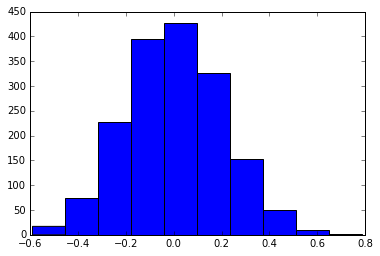

In [29]:
hist(ii_sim2[2]);

# Common Collaborative Filtering

In [30]:
def cf(pairs, rating_matrix, similarity_matrix, agg=lambda p, r: sum(p * r) / sum(p)):
    result = []
    for u, i in pairs:
        p = similarity_matrix[u, :]
        r = rating_matrix[:, i]
        rating = agg(p[r>0], r[r>0])
        if isnan(rating):
            rating = mean(rating_matrix[u, :])
        result.append(rating)
    return array(result)

In [31]:
def topk_agg(k):
    def agg(p, r):
        pi = argsort(p)
        sel_p = p[pi][-k:]
        sel_r = r[pi][-k:]
        return sum(sel_p[sel_p>0] * sel_r[sel_p>0]) / sum(sel_p[sel_p>0])
    return agg

# Cases Study

In [32]:
ipred1 = cf(
    zip(*nonzero(test_matrix.T)),
    train_matrix.T,
    ii_sim,
    topk_agg(30)
)

In [33]:
mae(test_matrix.T[nonzero(test_matrix.T)], ipred1)

0.8402881049983556

In [34]:
rmse(test_matrix.T[nonzero(test_matrix.T)], ipred1)

1.0578948521865974

In [35]:
ipred2 = cf(
    zip(*nonzero(test_matrix.T)),
    train_matrix.T,
    ii_sim2,
    topk_agg(30)
)

In [36]:
mae(test_matrix.T[nonzero(test_matrix.T)], ipred2)

0.84350109766410808

In [37]:
rmse(test_matrix.T[nonzero(test_matrix.T)], ipred2)

1.0586837774607312